In [13]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import ssl
from tqdm import tqdm
import urllib
import pgeocode
import plotly.express as px

In [2]:
alldfs = []
# loop across pages
for num in tqdm(range(10)): # can go up to 54 but at some point request gets blocked  so maybe need to run it at 2 different times
    request = "https://www.pple.fr/recherche/ain/Department-Ain?page="+ str(num+1)
    context = ssl._create_unverified_context()
    oh = urllib.request.urlopen(request,context=context)
    htmldata=oh.read()
    soup = BeautifulSoup(htmldata, "lxml")
    d = soup.find_all(class_="highlighted-result")

    # get names of companies
    e = soup.find_all('strong',{'class': 'highlighted-result'})
    names = [str(i).split('<strong class="highlighted-result">')[1].split('</strong>')[0].replace('<em>','').replace('</em>','') for i in e]
    names = [i.lower() for i in names]

    # get numero siret 
    f = soup.find_all(class_ = 'result-item-siren')
    siret = [str(i).split('<p class="result-item-siren">')[1].replace('  ','').split('\n')[2] for i in f]

    # get ape and description
    g = soup.find_all(class_ = "result-item-ape")
    ape = [str(i).split('<p class="result-item-ape">')[1].replace('  ','').split('\n')[2].replace(' -','') for i in g]
    description = [str(i).split('<p class="result-item-ape">')[1].replace('  ','').split('\n')[3] for i in g]

    # get postcode and city
    v = soup.find_all('span',{'class': 'highlighted-result'})#
    idx = []
    for num, i in enumerate(range(len(v))):
        if ' 01' in str(v[i]):
            idx.append(num)
    v = [v[i] for i in idx]
    locs = [str(i).split(' 0')[1].split('\n')[0].replace('<em>','').replace('</em>','') for i in v]
    locs = [i.lower() for i in locs]
    postcode = ['0' + i.split(' ')[0] for i in locs]
    city = [i.split(' ')[1] for i in locs]
    #create dataframe
    moby = {'noms':names,
        'siret': siret,
        'ape': ape,
        'description': description,
        'code postal': postcode,
        'ville': city}
    df = pd.DataFrame.from_dict(moby)
    alldfs.append(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]


In [4]:
ggdf = pd.concat(alldfs)

In [11]:
# retrieve latitude and longitude to be able to display on the map
nomi = pgeocode.Nominatim('fr')
coords = nomi.query_postal_code(ggdf['code postal'].values)
ggdf['latitude'] = coords['latitude'].values
ggdf['longitude'] = coords['longitude'].values

# add some random jitter to the coordinates otherwise everything gets plotted on the same spot
ggdf['longitude'] = [i+np.random.rand(1)[0]*1e-2 for i in ggdf['longitude'].values]
ggdf['latitude'] = [i+np.random.rand(1)[0]*1e-2 for i in ggdf['latitude'].values]


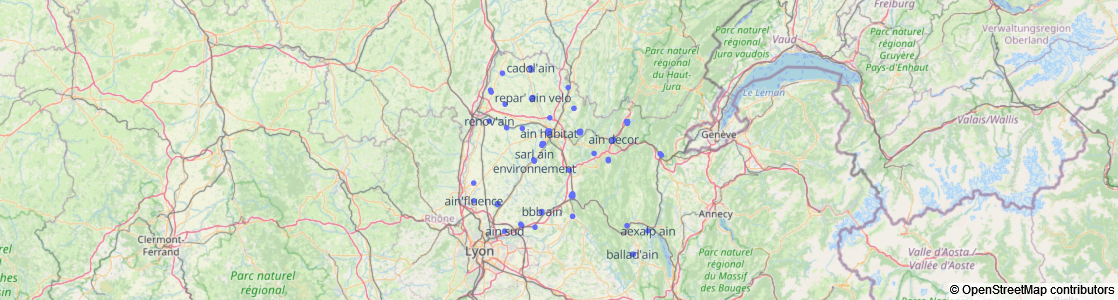

In [14]:
# quick and dirty plot
fig = px.scatter_mapbox(ggdf, lat="latitude", lon="longitude",text ="noms",  zoom=7, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()